In [1]:
import torch
from torch.utils.data import DataLoader
from mymodel import *
import matplotlib.pyplot as plt

In [2]:
dset_trn = SceneInstanceDataset(
    #instance_dir='C:/Users/Hanna/Desktop/geom_survey/cars_train/1ba30d64da90ea05283ffcfc40c29975/',
    instance_dir='C:/Users/Hanna/Desktop/geom_survey/cars_train/1a1dcd236a1e6133860800e6696b8284/',
    instance_idx=0,
    specific_observation_idcs=None,
    img_sidelength=64,
    num_images=16)

data_loader = DataLoader(dset_trn, batch_size=2)

dset_val = SceneInstanceDataset(
    #instance_dir='C:/Users/Hanna/Desktop/geom_survey/cars_train/1ba30d64da90ea05283ffcfc40c29975/',
    instance_dir='C:/Users/Hanna/Desktop/geom_survey/cars_train/1a1dcd236a1e6133860800e6696b8284/',
    instance_idx=0,
    specific_observation_idcs=None,
    img_sidelength=64,
    num_images=1)
val_data_loader = DataLoader(dset_val, batch_size=2)


In [3]:
class MySRN(nn.Module):
    def __init__(self):
        super().__init__()

        self.num_feature_ch=256
        self.render_layers=5
        self.l2_loss = nn.MSELoss(reduction="mean")
        self.ray_marcher = Raymarcher(num_feature_channels=self.num_feature_ch,
                            raymarch_steps=10)

        self.pixel_generator = FCBlock(
                        hidden_ch=self.num_feature_ch,
                        num_hidden_layers=self.render_layers - 1,
                        in_features=self.num_feature_ch,
                        out_features=3,
                        outermost_linear=True)

        for p in self.parameters():
            p.requires_grad = False

        self.phi = FCBlock(
                        hidden_ch=self.num_feature_ch,
                        num_hidden_layers=2,
                        in_features=3,
                        out_features=self.num_feature_ch)

    def get_regularization_loss(self, prediction, ground_truth):
        """Computes regularization loss on final depth map (L_{depth} in eq. 6 in paper)

        :param prediction (tuple): Output of forward pass.
        :param ground_truth: Ground-truth (unused).
        :return: Regularization loss on final depth map.
        直接加sigmoid 不加这个loss
        """
        _, depth = prediction

        neg_penalty = (torch.min(depth, torch.zeros_like(depth)) ** 2)
        return torch.mean(neg_penalty) * 10000

    def get_image_loss(self, pred_imgs, ground_truth):
        """Computes loss on predicted image (L_{img} in eq. 6 in paper)

        :param prediction (tuple): Output of forward pass.
        :param ground_truth: Ground-truth (unused).
        :return: image reconstruction loss.
        """
        #pred_imgs, _ = prediction
        trgt_imgs = ground_truth

        trgt_imgs = trgt_imgs.to(device)

        loss = self.l2_loss(pred_imgs, trgt_imgs)
        return loss


    def forward(self, input_instance, gnd=None):

        instance_idcs = input_instance["instance_idx"].long().to(device)
        pose = input_instance["pose"].to(device)
        intrinsics = input_instance["intrinsics"].to(device)
        uv = input_instance["uv"].to(device).to(torch.float32)

        end_world_xyz, end_dep, log = self.ray_marcher(
                                cam2world=pose,
                                intrinsics=intrinsics,
                                uv=uv,
                                phi=self.phi)
        v = self.phi(end_world_xyz)

        image_pred = self.pixel_generator(v)

        return image_pred

In [4]:
my_model = MySRN()
my_model.train()
my_model.to(device)

MySRN(
  (l2_loss): MSELoss()
  (ray_marcher): Raymarcher(
    (lstm): LSTMCell(256, 16)
    (out_layer): Linear(in_features=16, out_features=1, bias=True)
  )
  (pixel_generator): FCBlock(
    (net): Sequential(
      (0): FCLayer(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): FCLayer(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (2): ReLU(inplace=True)
        )
      )
      (2): FCLayer(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (2): ReLU(inplace=True)
        )
      )
      (3): FCLayer(
        (net): Sequential(
          (0): Linear(in_feature

In [5]:
ckpt_path = 'C:/Users/Hanna/Desktop/geom_survey/checkpoint/logs/checkpoints/epoch_0801_iter_100125.pth'
# '/content/gdrive/My Drive/RESEARCH/geom_survey/data/checkpoint/'
if ckpt_path is not None:
    print('Loading model from %s', ckpt_path)
    custom_load(my_model,
          path=ckpt_path)

Loading model from %s C:/Users/Hanna/Desktop/geom_survey/checkpoint/logs/checkpoints/epoch_0801_iter_100125.pth


In [6]:
logging_root = 'C:/Users/Hanna/Desktop/geom_survey/checkpoint/logs'
ckpt_dir = os.path.join(logging_root, 'checkpoints')
events_dir = os.path.join(logging_root, 'events')

cond_mkdir(logging_root)
cond_mkdir(ckpt_dir)
cond_mkdir(events_dir)

# Save text summary of model into log directory.
with open(os.path.join(logging_root, "model.txt"), "w") as out_file:
    out_file.write(str(my_model))


In [7]:
start_step = 0
steps_til_val = 1000      #Number of iterations until validation set is run
steps_til_ckpt = 10000    #Number of iterations until checkpoint is saved
l1_weight = 200.0
reg_weight = 1e-3

iter = start_step
epoch = iter // len(dset_trn)
step = 0

In [8]:
#optim = torch.optim.Adam(my_model.parameters(), lr = 5e-5)
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, my_model.parameters()), lr = 5e-5)

while epoch <= 800:
    for d in data_loader:

        optim.zero_grad()
        image_pred = my_model(d)

        img_loss = my_model.get_image_loss(image_pred, d['rgb'])
        regu_loss = my_model.get_regularization_loss(image_pred, d['rgb'])

        weighted_img_loss = l1_weight * img_loss
        weighted_regu_loss = reg_weight *regu_loss

        total_loss = img_loss + regu_loss

        total_loss.backward()
        optim.step()

        if iter % steps_til_val == 0:
            print('Running validation set...')

            my_model.eval()
            with torch.no_grad():
                dist_losses = []
                for val in val_data_loader:
                  break
                image_pred = my_model(val)
                #print(type(prediction))

                dist_loss = my_model.get_image_loss(image_pred, val['rgb']).cpu().numpy()
                dist_losses.append(dist_loss)

                my_model.train()
        iter += 1
        step += 1

        if iter % steps_til_ckpt == 0:
            custom_save(my_model,
                os.path.join(ckpt_dir, '1_epoch_%04d_iter_%06d.pth' % (epoch, iter)),
                discriminator=None,
                optimizer=optim)
    epoch += 1

custom_save(my_model,
      os.path.join(ckpt_dir, '1_epoch_%04d_iter_%06d.pth' % (epoch, iter)),
      discriminator=None,
      optimizer=optim)

.872819
Raymarch step 3: Min depth 0.674380, max depth 1.249720
Raymarch step 4: Min depth 0.875581, max depth 1.653575
Raymarch step 5: Min depth 0.955317, max depth 2.098246
Raymarch step 6: Min depth 0.951317, max depth 2.533254
Raymarch step 7: Min depth 0.955631, max depth 2.986025
Raymarch step 8: Min depth 0.957661, max depth 3.449497
Raymarch step 9: Min depth 0.958169, max depth 3.924309
Raymarch step 0: Min depth 0.048068, max depth 0.051721
Raymarch step 1: Min depth 0.269648, max depth 0.340894
Raymarch step 2: Min depth 0.544903, max depth 0.693639
Raymarch step 3: Min depth 0.810103, max depth 1.010622
Raymarch step 4: Min depth 0.842357, max depth 1.382815
Raymarch step 5: Min depth 0.783666, max depth 1.845903
Raymarch step 6: Min depth 0.791751, max depth 2.387359
Raymarch step 7: Min depth 0.805002, max depth 2.964172
Raymarch step 8: Min depth 0.808768, max depth 3.537863
Raymarch step 9: Min depth 0.812905, max depth 4.102918
Raymarch step 0: Min depth 0.048169, max

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Raymarch step 0: Min depth 0.047940, max depth 0.051693
Raymarch step 1: Min depth 0.193911, max depth 0.367883
Raymarch step 2: Min depth 0.395637, max depth 0.766639
Raymarch step 3: Min depth 0.613829, max depth 1.141656
Raymarch step 4: Min depth 0.809703, max depth 1.520235
Raymarch step 5: Min depth 0.853576, max depth 1.987916
Raymarch step 6: Min depth 0.868734, max depth 2.434369
Raymarch step 7: Min depth 0.871605, max depth 2.850131
Raymarch step 8: Min depth 0.876062, max depth 3.259366
Raymarch step 9: Min depth 0.879913, max depth 3.666794


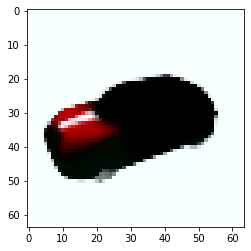

Raymarch step 0: Min depth 0.048009, max depth 0.052043
Raymarch step 1: Min depth 0.227952, max depth 0.344574
Raymarch step 2: Min depth 0.470816, max depth 0.690239
Raymarch step 3: Min depth 0.706199, max depth 1.001856
Raymarch step 4: Min depth 0.847437, max depth 1.348072
Raymarch step 5: Min depth 0.793036, max depth 1.815135
Raymarch step 6: Min depth 0.781124, max depth 2.356016
Raymarch step 7: Min depth 0.801946, max depth 2.923979


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 1.96 GiB already allocated; 3.73 GiB free; 449.22 MiB cached)

In [9]:
for i, d in enumerate(data_loader):
    if i < 4:
        pred_image = my_model(d)
        plt.imshow(pred_image[0, :, :].reshape(64, 64, 3).detach().cpu().numpy())

        
        plt.show()